# Implementado un Perceptrón multi-capa usando frameworks y MLFlow

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeffersonrodriguezc/deep-learning-en-3-semanas/blob/main/semana_1/notebooks/Nb_1c_Implementando_un_Percentron_Multiplicapa_MLP_usando_frameworks_MLFlow.ipynb)

In [1]:
#@title Importar librerías
#importar librerías necesarias
import json
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

!pip install mlflow --quiet

import mlflow
import mlflow.sklearn
import mlflow.tensorflow
from mlflow.tracking import MlflowClient

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.1/569.1 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.4 MB/s eta 0:00:00


In [2]:
#@title Configurando MLFlow
# configurar que el servidor de trackin sea localhost con una BD sqlite como el almacenamiento para almacenar el proceso de tracking

local_registry = "sqlite:///mlruns.db"
print(f"Ejecutando registro en modo local={local_registry}")
mlflow.set_tracking_uri(local_registry)

Ejecutando registro en modo local=sqlite:///mlruns.db


In [21]:
#@title Funciones complementarias
def plot_samples_dataset(X, y):
    # Convertir las etiquetas a enteros
    y = y.astype(int)

    # Crear la grilla de 4x4
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    fig.suptitle('Grilla de imágenes del dataset MNIST')

    # Iterar para mostrar las primeras 16 imágenes con sus etiquetas
    for i, ax in enumerate(axes.flat):
        img = X.iloc[i].values.reshape(28, 28)
        label = y[i]
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')

    plt.show()

def plot_curva_aprendizaje(mlp):
    plt.figure(figsize=(8, 5))
    plt.plot(mlp.loss_curve_, marker='o')
    plt.title('Pérdida durante el entrenamiento del MLP por iteración')
    plt.xlabel('Iteración')
    plt.ylabel('Pérdida (Loss)')
    plt.grid()
    plt.show()

def plot_matriz_confusion(cm, nombre):
    # Visualizar la matriz de confusión usando Seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Etiqueta predicha')
    plt.ylabel('Etiqueta real')
    plt.title('Matriz de Confusión para el MLP en el dataset MNIST')
    plt.show()
    plt.savefig(f"{nombre}.png")

def encontrar_dim_imagen(n_neurons):
    """
    Encuentra la mejor forma cuadrada (filas, columnas) para una cantidad dada de neuronas.
    """
    side_length = int(np.sqrt(n_neurons))  # Calcular la raíz cuadrada del número de neuronas
    if side_length * side_length == n_neurons:
        return (side_length, side_length)  # Si es un cuadrado perfecto
    else:
        # Si no es un cuadrado perfecto, buscamos la mejor aproximación (filas, columnas)
        for i in range(side_length, 0, -1):
            if n_neurons % i == 0:
                return (i, n_neurons // i)  # Devolver filas y columnas
    return (n_neurons, 1)  # Si no encuentra, retornar en forma de vector (n_neurons, 1)

def visualizacion_pesos_mlp(mlp):
    # Definir la figura con 3 filas y 5 columnas
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))

    # Asignar las dimensiones para visualizar cada capa
    layer_shapes = [encontrar_dim_imagen(layer.shape[0]) for layer in mlp.coefs_]

    # Recorrer cada capa de coeficientes del MLP
    for layer_index, (layer_coefs, ax_row) in enumerate(zip(mlp.coefs_, axes)):
        # Seleccionar aleatoriamente 5 neuronas de la capa actual
        num_neurons = layer_coefs.shape[1]
        random_neurons = random.sample(range(num_neurons), 5)

        # Obtener la forma de visualización para esta capa
        layer_shape = layer_shapes[layer_index]

        vmin, vmax = layer_coefs.min(), layer_coefs.max()

        # Visualizar las neuronas seleccionadas
        for neuron_index, ax in zip(random_neurons, ax_row):
            # Seleccionar los pesos de la neurona específica y reestructurarlos en una matriz 2D
            neuron_weights = layer_coefs[:, neuron_index].reshape(layer_shape)
            # Dibujar la imagen de los pesos de la neurona
            ax.matshow(neuron_weights, cmap=plt.cm.gray, vmin=0.5 * vmin, vmax=0.5 * vmax)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f'Capa {layer_index+1}, Neurona {neuron_index}')

    plt.suptitle('Visualización de Pesos de las Neuronas en las Capas Ocultas')
    plt.tight_layout()
    plt.show()

def plot_loss_historia_keras(history):
    # Graficar el histórico de pérdida durante el entrenamiento
    plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de Validación')
    plt.title('Pérdida durante el Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()

def plot_acc_historia_keras(history):
    # Graficar la precisión durante el entrenamiento
    plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
    plt.title('Precisión durante el Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.legend()
    plt.show()

def visualizacion_pesos_mlp_keras(model):
    # Obtener los pesos del modelo (par de listas [pesos, biases] para cada capa)
    weights = model.get_weights()

    # Extraer solo los pesos de cada capa oculta, ignorando los bias
    layer_weights = [weights[i] for i in range(0, len(weights), 2)]  # Solo los pesos, no los sesgos

    # Definir la figura con 3 filas (una por cada capa) y 5 columnas (5 neuronas al azar)
    fig, axes = plt.subplots(len(layer_weights), 5, figsize=(15, 9))

    # Calcular las formas de cada capa de manera dinámica
    layer_shapes = [encontrar_dim_imagen(layer.shape[0]) for layer in layer_weights]

    # Recorrer cada capa y sus pesos
    for layer_index, (layer_coefs, ax_row) in enumerate(zip(layer_weights, axes)):
        # Seleccionar aleatoriamente 5 neuronas de la capa actual
        num_neurons = layer_coefs.shape[1]
        random_neurons = random.sample(range(num_neurons), 5)

        # Obtener la forma de visualización para esta capa
        layer_shape = layer_shapes[layer_index]
        vmin, vmax = layer_coefs.min(), layer_coefs.max()


        # Visualizar las neuronas seleccionadas
        for neuron_index, ax in zip(random_neurons, ax_row):
            # Seleccionar los pesos de la neurona específica y reestructurarlos en una matriz 2D
            neuron_weights = layer_coefs[:, neuron_index].reshape(layer_shape)
            # Dibujar la imagen de los pesos de la neurona
            ax.matshow(neuron_weights, cmap=plt.cm.gray, vmin=0.5 * vmin, vmax=0.5 * vmax)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f'Capa {layer_index+1}, Neurona {neuron_index}')

    plt.suptitle('Visualización de Pesos de las Neuronas en las Capas Ocultas de Keras')
    plt.tight_layout()
    plt.show()

# Dataset MNIST (Clasificación multiclase)

Trabajaremos con el clásico dataset de imágenes de digitos escritos a mano. Esta dataset puede ser descargado de diversas fuentes incluido sklearn.

In [4]:
# Cargar el dataset de MNIST
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']

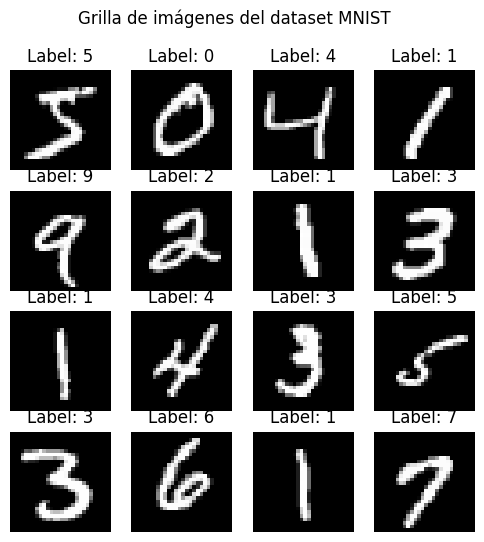

In [5]:
# Visualizamos algunas imágenes
plot_samples_dataset(X, y)

Un breve vistazo del dataset nos indica que la mayoría de pixeles de la imágen estan en 0 y que los que tiene valor estan en 255. Esta escala, es los valores de intensidad en escala de grises. Además, vemos que la información esta organizada en un dataframe con 784 columnas lo que se traduce en una versión vectorizada de una imágen de 28x28 píxeles.

In [6]:
X.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,...,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.0,70000.0,70000.0,70000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.197414,0.099543,0.046629,0.016614,0.012957,0.001714,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.991206,4.256304,2.783732,1.561822,1.553796,0.320889,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.000000,0.0,0.0,0.0,0.0


Antes de hacer la división del conjunto de datos, podemos hacer una normalización de los valores de los píxeles para que esten entre 0-1, así es más fácil para la red optimizar la función de pérdida.

In [7]:
# Normalización
X = X / 255.

In [8]:
# usar train test split para dividir los datos X y y
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30,  random_state=42)

print('Dimensión X_train: {}'.format(X_train.shape))
print('Dimensión X_test: {}'.format(X_test.shape))

Dimensión X_train: (49000, 784)
Dimensión X_test: (21000, 784)


# MLP clasificador multiclase en Sklearn

Seguidamente, vamos a crear un clasificador MLP usando la librería sklearn, pueden encontrar toda la documentación en: [Documentación MLP](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).

In [9]:
mlp = MLPClassifier(hidden_layer_sizes=(225, 100), activation = 'relu',
                    max_iter=30, alpha=1e-4,
                    solver='sgd', verbose=10, random_state=1,
                    learning_rate = 'adaptive',
                    learning_rate_init = 0.1,
                    early_stopping=False, validation_fraction=0.2)

mlp

MLPClassifier(hidden_layer_sizes=(225, 100), learning_rate='adaptive',
              learning_rate_init=0.1, max_iter=30, random_state=1, solver='sgd',
              validation_fraction=0.2, verbose=10)

### Seguimiento de experimentos con [MLFlow](https://mlflow.org/docs/latest/index.html)

In [10]:
experiment_name = "MNIST_MLP_Sklearn"
with mlflow.start_run(run_name=experiment_name) as run:
    # Registrar parámetros del modelo
    mlflow.log_param("hidden_layer_sizes", (225, 100))
    mlflow.log_param("activation", "relu")
    mlflow.log_param("solver", "sgd")
    mlflow.log_param("learning_rate", "adaptive")
    mlflow.log_param("learning_rate_init", 0.1)

    # Entrenar el modelo
    history = mlp.fit(X_train, y_train)

    # Registrat métricas
    train_score = mlp.score(X_train, y_train)
    test_score = mlp.score(X_test, y_test)
    mlflow.log_metric("train_score", train_score)
    mlflow.log_metric("test_score", test_score)

    # Log and register the model at the same time
    mlflow.sklearn.log_model(
                sk_model = mlp,
                artifact_path = "sklearn-model",
                registered_model_name=experiment_name)

    run_id = run.info.run_uuid
    print(run_id)

2024/11/05 14:54:56 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/11/05 14:54:56 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

Iteration 1, loss = 0.29809553
Iteration 2, loss = 0.10153217
Iteration 3, loss = 0.07025477
Iteration 4, loss = 0.05107289
Iteration 5, loss = 0.03813628
Iteration 6, loss = 0.02863240
Iteration 7, loss = 0.02136907
Iteration 8, loss = 0.01639116
Iteration 9, loss = 0.01391393
Iteration 10, loss = 0.00862180
Iteration 11, loss = 0.00514989
Iteration 12, loss = 0.00551735
Iteration 13, loss = 0.00416624
Iteration 14, loss = 0.00174071
Iteration 15, loss = 0.00094037
Iteration 16, loss = 0.00082533
Iteration 17, loss = 0.00067903
Iteration 18, loss = 0.00057994
Iteration 19, loss = 0.00053067
Iteration 20, loss = 0.00050842
Iteration 21, loss = 0.00048905
Iteration 22, loss = 0.00047281
Iteration 23, loss = 0.00045934
Iteration 24, loss = 0.00044890
Iteration 25, loss = 0.00043982
Iteration 26, loss = 0.00042988
Iteration 27, loss = 0.00042256
Iteration 28, loss = 0.00041607
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Setting learning rate to 0.020000

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
2024/11/05 14:57:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


833e0c3c36ce4ae798373b3255e88fb2


Successfully registered model 'MNIST_MLP_Sklearn'.
Created version '1' of model 'MNIST_MLP_Sklearn'.


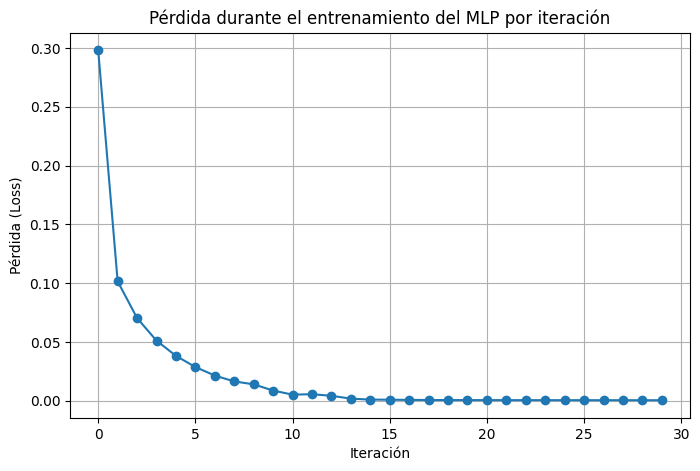

In [11]:
# imprimir la curva de evolución de la pérdida
plot_curva_aprendizaje(mlp)

## Evaluación completa

Realizaremos una evaluación completa revisando el rendimiento en ambos conjuntos, seguidamente generaremos el reporte de clasificación y la matriz de confusión.

In [12]:
print(f"Training set score: {mlp.score(X_train, y_train):.3f}")
print(f"Test set score: {mlp.score(X_test, y_test):.3f}")

Training set score: 1.000
Test set score: 0.982


Reporte de Clasificación del MLP en MNIST:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2058
           1       0.99      0.99      0.99      2364
           2       0.98      0.98      0.98      2133
           3       0.98      0.98      0.98      2176
           4       0.98      0.98      0.98      1936
           5       0.98      0.98      0.98      1915
           6       0.98      0.99      0.99      2088
           7       0.98      0.98      0.98      2248
           8       0.98      0.97      0.97      1992
           9       0.98      0.97      0.98      2090

    accuracy                           0.98     21000
   macro avg       0.98      0.98      0.98     21000
weighted avg       0.98      0.98      0.98     21000



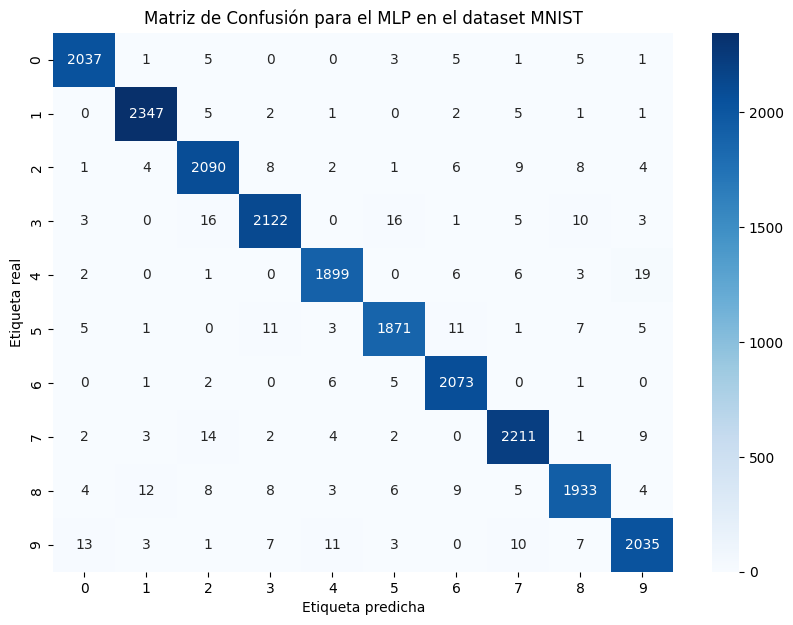

<Figure size 640x480 with 0 Axes>

In [14]:
# re abrir un run anterior para registrar más datos
mlflow.start_run(run_id=run_id)

# Realizar predicciones
y_pred = mlp.predict(X_test)

# Imprimir el reporte de métricas
print("Reporte de Clasificación del MLP en MNIST:\n")
report = classification_report(y_test, y_pred)
print(report)

# registrar artefacto
with open("classification_report.json", "w") as f:
    json.dump(report, f)
mlflow.log_artifact("classification_report.json")

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# visualizar la matriz de confusión
plot_matriz_confusion(cm, nombre='confusion_matrix')
# Guardar la visualización como imagen y registrarla en MLflow
mlflow.log_artifact("confusion_matrix.png")

# Finalizar el `run` si ya no se va a registrar nada más
mlflow.end_run()

### Ejecutar MLFlow UI

In [15]:
# Ejecutar tracking UI en background
get_ipython().system_raw("mlflow ui --backend-store-uri sqlite:///mlruns.db --port 5000 &")

In [20]:
# Crear un tunel remoto usando ngrok.com
!pip install -U pyngrok --quiet
from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Colocar el token
# Coloque su authtoken obtenido de https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2oR7ctXTRQ7kJl8csoQXXoxsb6V_72fsChgD1kFQN5MkVr7U3"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Abrir el tunel http en el puerto 5000 para http://localhost:5000
public_url = ngrok.connect("http://localhost:5000", proto='http')
print("MLflow Tracking UI:", public_url)

MLflow Tracking UI: NgrokTunnel: "https://3ec3-34-125-33-68.ngrok-free.app" -> "http://localhost:5000"


## Visualización de pesos

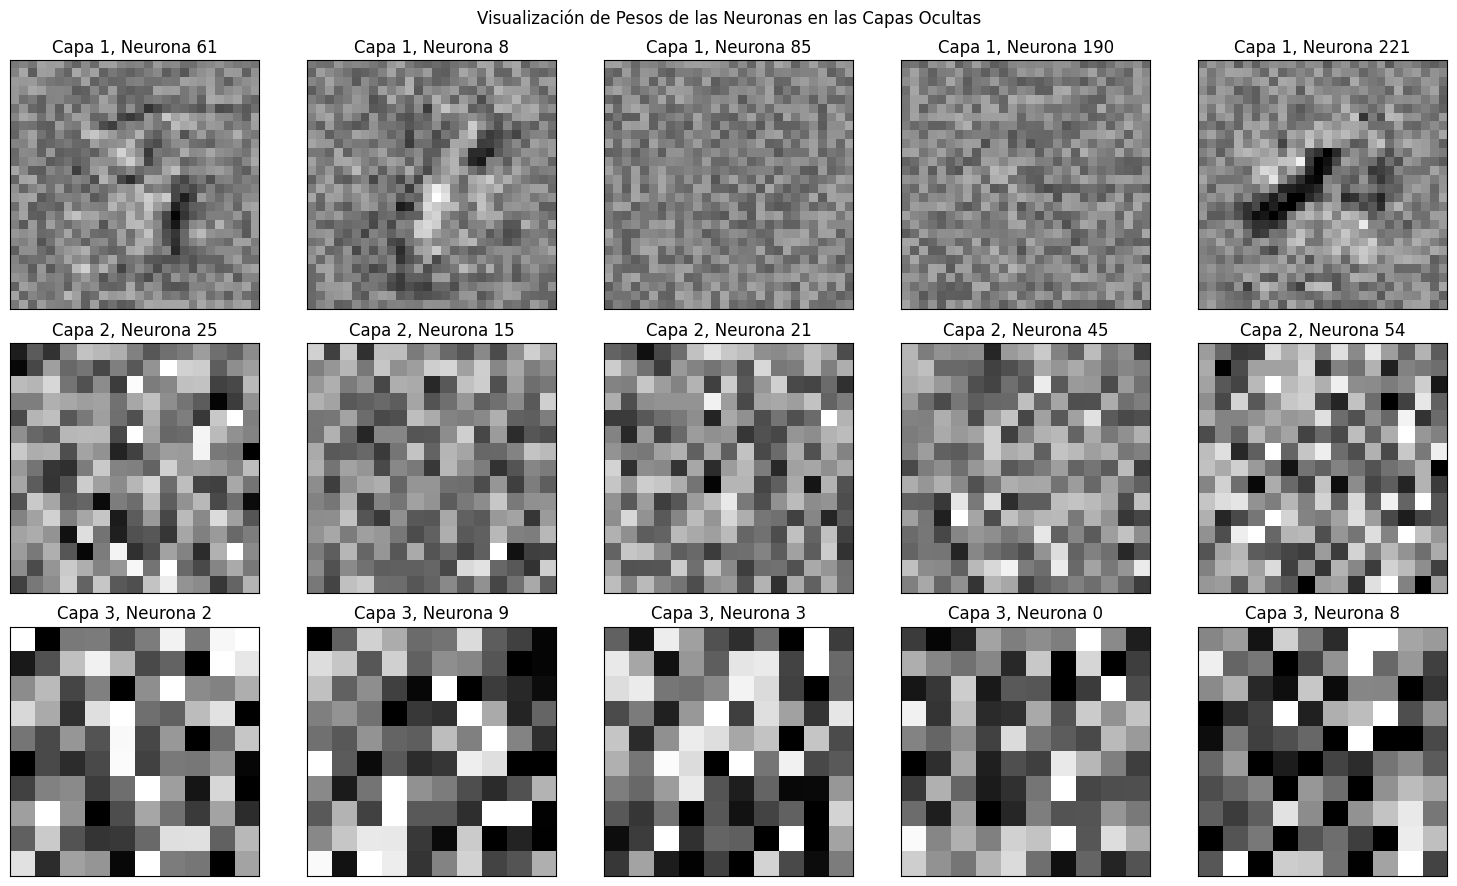

In [ ]:
visualizacion_pesos_mlp(mlp)

### Tutoriales relacionados

* [Análisis de la variación del parametro de regularización alpha](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html#sphx-glr-auto-examples-neural-networks-plot-mlp-alpha-py)
* [Comparación de las diferentes estrategias de aprendizaje](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html#sphx-glr-auto-examples-neural-networks-plot-mlp-training-curves-py)

# MLP Clasificador multiclase en keras

In [ ]:
# Asumiendo que X_train y y_train ya están definidos como en el ejemplo anterior
# Preprocesar las etiquetas para que sean categóricas (one-hot encoding)
y_train_categorical = to_categorical(y_train)
y_train_categorical

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# crear modelo usando el API secuencial
def MLPClassifier_keras():
    # Definir el modelo similar al de sklearn
    model = Sequential()
    model.add(Input(shape=(784,)))
    model.add(Dense(225, activation='relu'))  # Primera capa con 225 neuronas
    model.add(Dropout(0.3))  # Regularización con Dropout
    model.add(Dense(100, activation='relu'))  # Segunda capa con 100 neuronas
    model.add(Dropout(0.3))  # Regularización con Dropout
    model.add(Dense(10, activation='softmax'))  # Capa de salida para 10 clases

    return model

In [ ]:
mlp_keras = MLPClassifier_keras()

In [ ]:
# Compilar el modelo
mlp_keras.compile(loss='categorical_crossentropy',
            optimizer=SGD(),
            metrics=['accuracy'])

# Entrenar el modelo
history = mlp_keras.fit(X_train.values.astype(float), y_train_categorical,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3342 - loss: 1.9841 - val_accuracy: 0.8077 - val_loss: 0.9699
Epoch 2/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6913 - loss: 1.0380 - val_accuracy: 0.8551 - val_loss: 0.5885
Epoch 3/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7718 - loss: 0.7515 - val_accuracy: 0.8785 - val_loss: 0.4627
Epoch 4/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8130 - loss: 0.6290 - val_accuracy: 0.8920 - val_loss: 0.4014
Epoch 5/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8357 - loss: 0.5519 - val_accuracy: 0.8982 - val_loss: 0.3635
Epoch 6/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8546 - loss: 0.4972 - val_accuracy: 0.9065 - val_loss: 0.3365
Epoch 7/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8667 - loss: 0.4594 - val_accuracy: 0.9094 - val_loss: 0.3168
Epoch 8/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8735 - loss: 0.4353 - val_accuracy

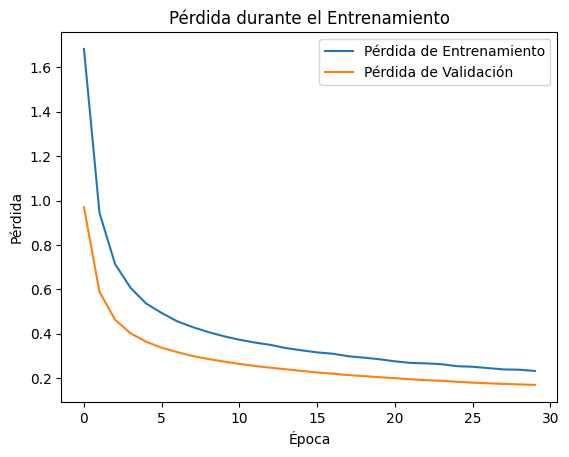

In [ ]:
plot_loss_historia_keras(history)

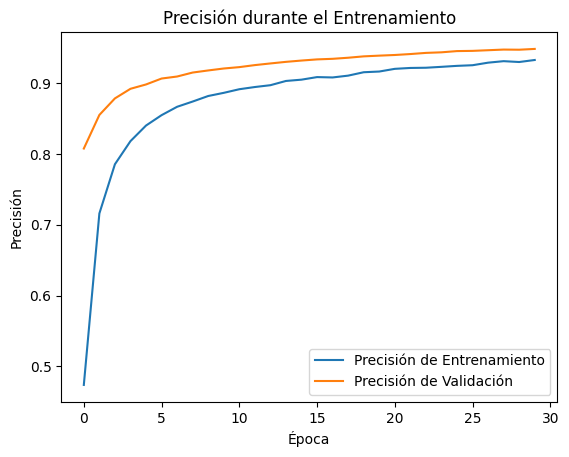

In [ ]:
plot_acc_historia_keras(history)

## Evaluación completa

In [ ]:
y_test_categorical = to_categorical(y_test)

score = mlp_keras.evaluate(X_test.values.astype(float), y_test_categorical, batch_size=128)

score

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9481 - loss: 0.1761


[0.17650671303272247, 0.9479047656059265]

In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = mlp_keras.predict(X_test.values.astype(float))

# Convertir las predicciones en etiquetas (la clase con mayor probabilidad)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test.values.astype(int)  # Las etiquetas reales del conjunto de prueba

657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


Reporte de Clasificación para el MLP en MNIST:

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2058
           1       0.96      0.98      0.97      2364
           2       0.96      0.93      0.95      2133
           3       0.93      0.93      0.93      2176
           4       0.94      0.96      0.95      1936
           5       0.95      0.93      0.94      1915
           6       0.96      0.97      0.96      2088
           7       0.95      0.95      0.95      2248
           8       0.95      0.92      0.93      1992
           9       0.93      0.93      0.93      2090

    accuracy                           0.95     21000
   macro avg       0.95      0.95      0.95     21000
weighted avg       0.95      0.95      0.95     21000



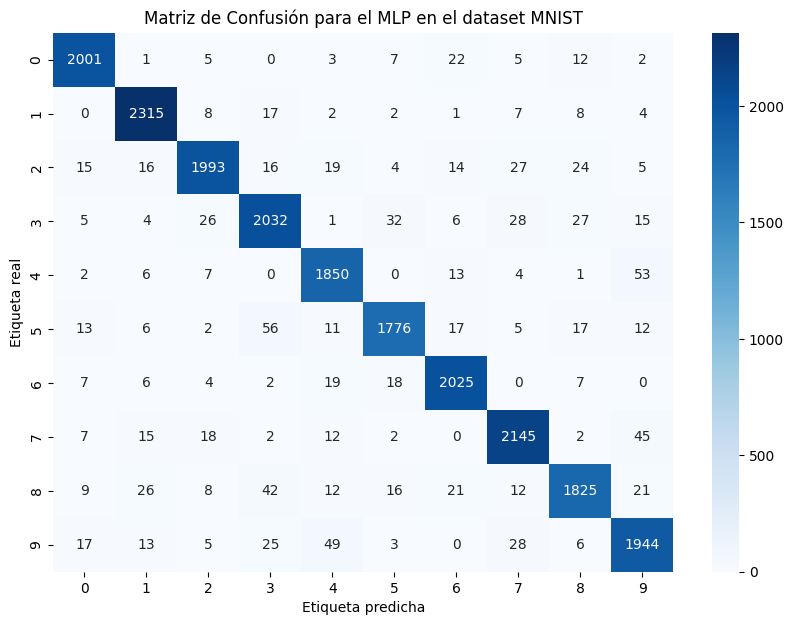

In [ ]:
# Generar el reporte de clasificación
print("Reporte de Clasificación para el MLP en MNIST:\n")
print(classification_report(y_true, y_pred_classes))

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)

# Visualizar la matriz de confusión usando Seaborn
plot_matriz_confusion(cm)

## Visualización de pesos

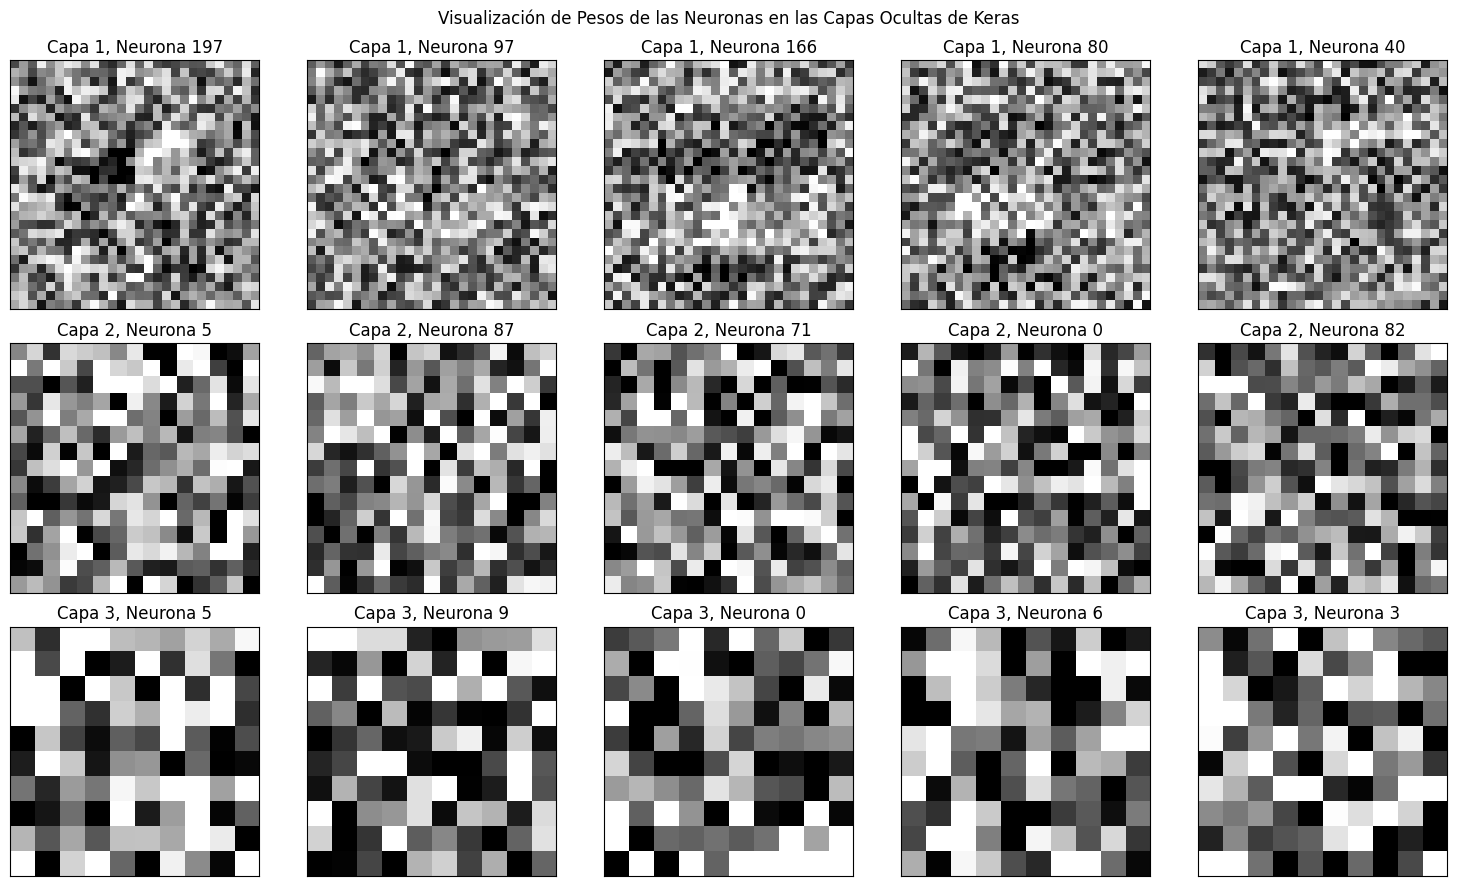

In [ ]:
visualizacion_pesos_mlp_keras(mlp_keras)

## Actividad extra clase

Usando la siguiente documentación: https://mlflow.org/docs/latest/deep-learning/tensorflow/guide/index.html realizar un seguimiento y registro del MLP construido en keras/tensorflow.